In [1]:
import numpy as np;
from numpy import linalg as LA
import seaborn as sns; sns.set()
from random import choices
import matplotlib.pyplot as plt

In [2]:
#givens
n=20
sigma = 10
discount_factor = 0.95
eye = np.array([15,15])
goal = (19,9)
start = (9,19)

In [3]:
#initialize values, storm influence (storm_inf), state space, and reward arrays.
values=np.zeros([n,n])
storm_inf=np.zeros([n,n])
reward = np.zeros([n,n])
reward[goal[0], goal[1]] = 1
states = []
for i in range(n):
    for j in range(n):
        states.append((i,j))

In [4]:
#calculate p(x) for all locations on the grid, store in storm_inf
for i in range(0,n):
    for j in range(0,n):
        storm_inf[i][j] = np.exp(-((LA.norm(np.array([i,j])-eye))**2)/(2*sigma**2))

In [5]:
def next_pos(state,action,direction,n=n):
    """
    Args:
    n is size of board
    state is position on grid (x1,x2)
    action is the called for movement
    direction is the actual direction of movement
    0:up    (x1,x2)->(x1-1, x2  )
    1:down  (x1,x2)->(x1+1, x2  )
    2:left  (x1,x2)->(x1,   x2-1)
    3:right (x1,x2)->(x1,   x2+1)  
    
    given a direction and an action (up, down, left, right)
    return the new state in that direction with the probability of moving in that direction
    up: (x1,x2) -> (x1-1, x2)
    down: (x1,x2) -> (x1+1, x2)
    left: (x1,x2) -> (x1, x2-1)
    right: (x1,x2) -> (x1, x2+1)
    
    If the action takes you beyond the boundary of the board, do nothing"""
    
    x1=state[0]
    x2=state[1]
    x1_n = 0 
    x2_n = 0
    prob = 0
    if [x1,x2] == goal:
        x1_n,x2_n=x1,x2
        prob = 0.25
    else:
        if direction == 0:
            x1_n = max(x1 - 1,0)
            x2_n = x2
        if direction == 1:
            x1_n = min(x1 + 1, n-1)
            x2_n = x2    
        if direction == 2:
            x1_n = x1
            x2_n = max(x2 - 1,0)
        if direction == 3:
            x1_n = x1 
            x2_n = min(x2 + 1,n-1)
        prob = get_prob((x1,x2), action, direction)
    return (x1_n, x2_n), prob

In [6]:
def get_prob(state,a,d,p=storm_inf):
    """
    Args:
    state: position on grid (x1,x2)
    a: direction [0,1,2,3] called for by the action [up, down, left, right] (used to check probability function)
    d: direction [0,1,2,3] of movement
    p: probability p(x) outlined in problem formulation
    
    returns:
    prob: probability of ending up in the direction d given a specified action a
    """
    x1=state[0]
    x2=state[1]
    prob=0
    if d==a:
        prob = p[x1][x2]/4 + (1-p[x1][x2])
    else:
        prob = p[x1][x2]/4
    return prob
    

In [7]:
def next_state_value(V, a, s, gamma=discount_factor):
    """
    Args:
    V: value function at current step
    a: action
    s: current state
    
    returns:
    Value at next state
    """
    dir_value=0
    for d in range(4):
        next_state, prob = next_pos(s,a,d)
        new_reward = reward[next_state[0]][next_state[1]]
        new_value = V[next_state[0]][next_state[1]]
        dir_value+=prob*(new_reward+gamma*new_value)
    #dir_value = min(dir_value, 1)
    return dir_value

In [8]:
def update_value_function(v,states=states):
    v_new = np.zeros([v.shape[0],v.shape[1]])
    p_new = np.zeros([v.shape[0],v.shape[1]])
    for state in states:
        if state == (19,9):
            v_new[19][9]=1
            continue
        action_value = np.zeros(4)
        for a in range(4):
            action_value[a]=next_state_value(v,a,state)
        best_value = np.max(action_value)
        best_action=np.argmax(action_value)
        v_new[state[0]][state[1]] = best_value
        p_new[state[0]][state[1]] = best_action
    return v_new, p_new

In [9]:
def value_iter(v, epsilon,gamma):
    v_current=v
    delta = 1
    while delta>epsilon:
        v_new, p_new=update_value_function(v_current)
        delta=LA.norm(v_new-v_current)
        v_current = v_new
    return v_new, p_new

In [10]:
value,policy=value_iter(values,.01,discount_factor)
print(value)

[[0.18463058 0.18267581 0.17990018 0.17529235 0.1677904  0.15763153
  0.14780316 0.13828365 0.12906865 0.1201483  0.11152986 0.10321421
  0.09521797 0.08754903 0.08022885 0.07326693 0.06668429 0.06048985
  0.05473467 0.04979321]
 [0.19550736 0.1935692  0.19085152 0.1862294  0.1784959  0.16751631
  0.15623537 0.14536995 0.13490565 0.12484928 0.11519303 0.10595322
  0.09712763 0.0887402  0.08079073 0.07330594 0.06628221 0.05974782
  0.05373878 0.04870835]
 [0.20751334 0.20568487 0.20315523 0.1986489  0.19080918 0.1792681
  0.1666439  0.15442797 0.14263571 0.13127165 0.12036495 0.10992737
  0.09999809 0.09059017 0.08174613 0.07347146 0.06580284 0.05873753
  0.05236404 0.0471674 ]
 [0.22048325 0.21883453 0.21659654 0.21232533 0.20447862 0.19243906
  0.17827947 0.16454257 0.15123358 0.13838476 0.1260206  0.11419587
  0.10294767 0.092344   0.08241891 0.07323401 0.06479984 0.05716402
  0.05039034 0.0450689 ]
 [0.23452065 0.23313738 0.23132596 0.2274363  0.21972832 0.20727872
  0.19135398 0.17

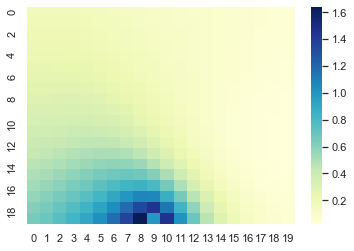

In [11]:
heatmap = sns.heatmap(value, cmap="YlGnBu")
fig=heatmap.get_figure()
fig.savefig('heatmap.png')

In [ ]:
print(policy)

In [12]:
def compute_trajectory(p, start = start, goal = goal):
    traj = []
    state = start
    while state != goal:
        density = [0,0,0,0]
        new_state = [0,0,0,0]
        action = p[state[0]][state[1]]
        for d in range(4):
            new_state[d], density[d] = next_pos(state, action, d)
        next_state = choices(new_state, density)
        traj.append([state,action,next_state[0]])
        state = next_state[0]
    return traj

In [14]:
traj=compute_trajectory(policy)
x1=np.zeros(len(traj))
x2=np.zeros(len(traj))
for t in range(len(traj)):
    x1[t]=traj[t][0][0]
    x2[t]=traj[t][0][1]


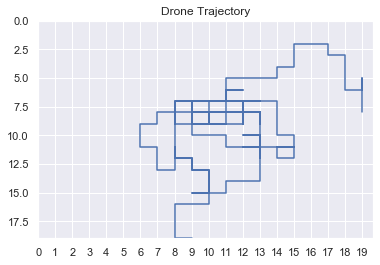

In [15]:
plt.plot(x1,x2)
plt.title('Drone Trajectory')
plt.xticks(np.arange(0,20, step=1.0))
plt.ylim(19,0)
plt.savefig("Drone Trajectory1.png",bbox_inches="tight",dpi=600) 
plt.show() 